# Credit Default

* [Подключение библиотек и скриптов](#libraries)
* [Пути к файлам](#filed)
* [Загрузка данных](#loading)
* [Обзор данных](#data)
* [Обработка выбросов](#outlier)
* [Обработка пропусков](#omission)
* [Функция подготовки исходных данных](#preprocessing)
* [Построение новых признаков](#new_features)
* [Функция построения новых признаков](#generator)
* [Отбор признаков](#feature_selection)
* [Разбиение на train и test](#train_test)
* [Построение модели](#model)
* [Прогнозирование на тестовом датасете](#prediction)


## Подключение библиотек и скриптов<a class='anchor' id='libraries'></a>

In [1]:
#1. Основные библиотеки
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#2. Разделение датачета
from sklearn.model_selection import train_test_split

#3. Метрики качества
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

#4.Используемая модель
import catboost as catb

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [3]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [4]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Пути к файлам <a class='anchor' id='files'></a>

In [6]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
SUBMISSION_DATASET_PATH = 'sample_submission.csv'

## Загрузка данных <a class='anchor' id='loading'></a>

### Описание датасета:

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.58 MB
Decreased by 40.4%


In [8]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
train_df.shape

(7500, 17)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float32
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float32
 4   Number of Open Accounts       7500 non-null   float32
 5   Years of Credit History       7500 non-null   float32
 6   Maximum Open Credit           7500 non-null   float32
 7   Number of Credit Problems     7500 non-null   float32
 8   Months since last delinquent  3419 non-null   float32
 9   Bankruptcies                  7486 non-null   float32
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float32
 13  Cur

## Обзор данных <a class='anchor' id='data'></a>

**Обзор целевой переменной**

In [11]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

## Обработка выбросов<a class='anchor' id='outlier'></a>

In [12]:
df_num_features = train_df.select_dtypes(include=['float32', 'int8'])
df_num_features.drop('Credit Default', axis=1, inplace=True)

In [13]:
df_num_features.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,100000000.0,47386.0,7914.0,749.0
1,1025487.0,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,100000000.0,308389.0,13651.0,742.0
3,805068.0,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,125840.0,93309.0,7180.0,719.0


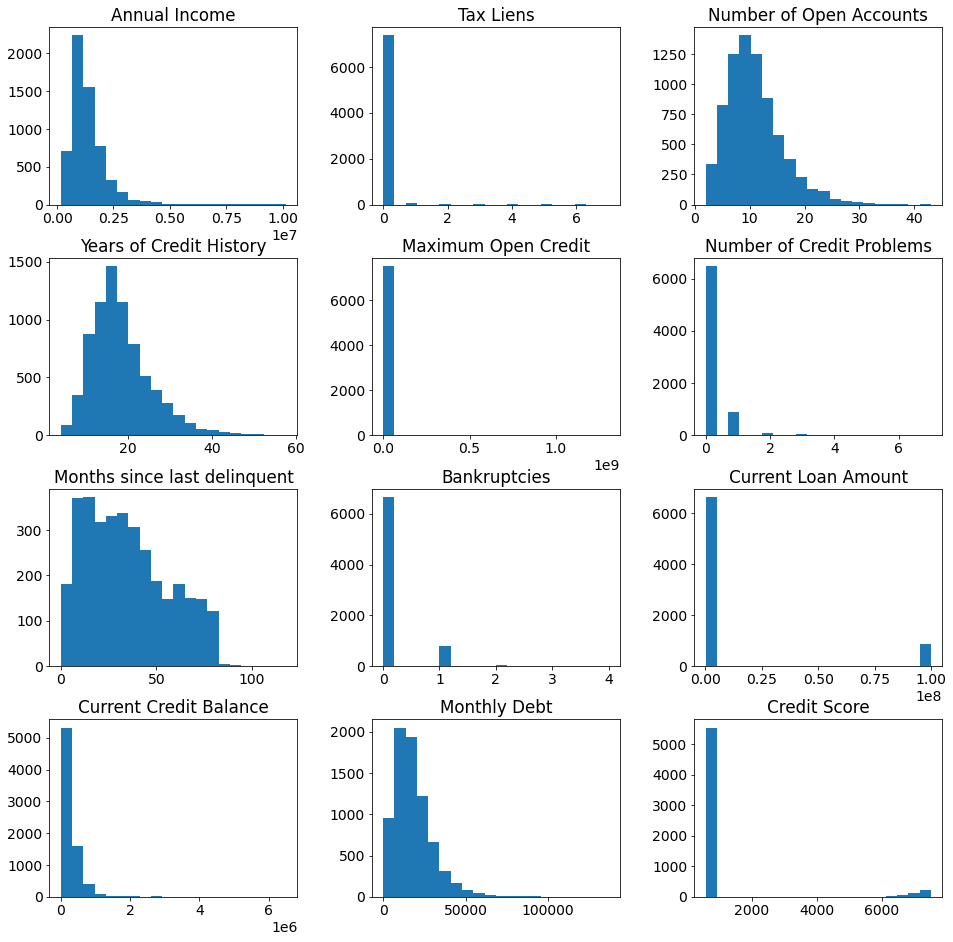

In [14]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

**Annual Income**

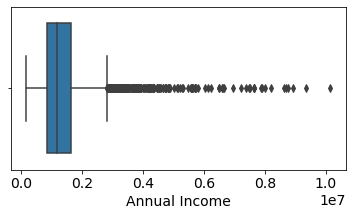

In [15]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Annual Income'], whis=1.5)

plt.xlabel('Annual Income')
plt.show()

<AxesSubplot:>

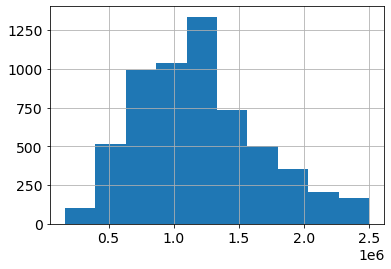

In [16]:
train_df.loc[(train_df['Annual Income'] > 2500000), 'Annual Income'] = train_df['Annual Income'].median()
train_df['Annual Income'].hist()

**Current Credit Balance**

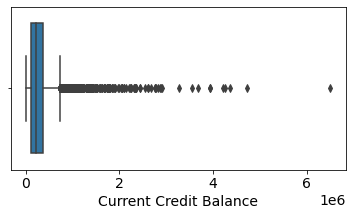

In [17]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Current Credit Balance'], whis=1.5)

plt.xlabel('Current Credit Balance')
plt.show()

<AxesSubplot:>

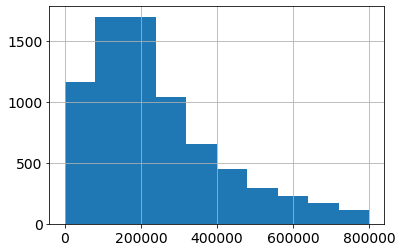

In [18]:
train_df.loc[(train_df['Current Credit Balance'] > 800000), 'Current Credit Balance'] = train_df['Current Credit Balance'].median()
train_df['Current Credit Balance'].hist()

**Monthly Debt**

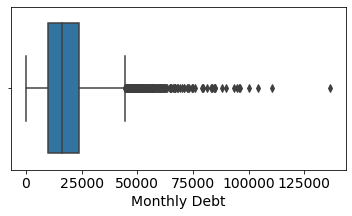

In [19]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Monthly Debt'], whis=1.5)

plt.xlabel('Monthly Debt')
plt.show()

<AxesSubplot:>

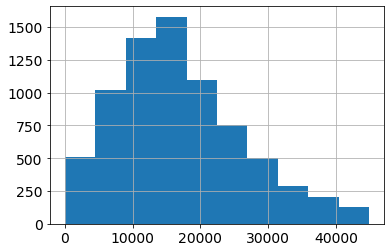

In [20]:
train_df.loc[(train_df['Monthly Debt'] > 45000), 'Monthly Debt'] = train_df['Monthly Debt'].median()
train_df['Monthly Debt'].hist()

**Maximum Open Credit**

In [21]:
max_credit = 99999999.0

In [22]:
train_df[train_df['Maximum Open Credit'] > max_credit]['Maximum Open Credit'].value_counts()

3.800523e+08    1
1.304726e+09    1
2.655129e+08    1
Name: Maximum Open Credit, dtype: int64

In [23]:
train_df['Maximum Open Credit Outlier'] = 0
train_df.loc[train_df['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
train_df.loc[train_df['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = max_credit

In [24]:
train_df[train_df['Maximum Open Credit Outlier'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Maximum Open Credit Outlier
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,100000000.0,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0,1
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,100000000.0,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,209323.0,5492.0,NaN,0,1
2617,Home Mortgage,1168386.0,10+ years,0.0,12.0,35.5,100000000.0,0.0,NaN,0.0,other,Short Term,50116.0,209323.0,20272.0,750.0,0,1


**Current Loan Amount**

In [25]:
train_df['Current Loan Amount'].value_counts()

100000000.0    870
218064.0         6
89298.0          6
222926.0         5
265826.0         5
              ... 
351626.0         1
212498.0         1
187682.0         1
108922.0         1
26928.0          1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [26]:
train_df['Current Loan Amount Outlier'] = 0
train_df.loc[train_df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount Outlier'] = 1
train_df.loc[train_df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = train_df['Current Loan Amount'].median()

In [27]:
train_df[train_df['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].count()

0

**Credit Score**

In [28]:
train_df[train_df['Credit Score'] <= 850]['Credit Score'].count()

5543

In [29]:
train_df[train_df['Credit Score'] > 1000]['Credit Score'].count()

400

In [30]:
train_df['Credit Score Outlier'] = 0
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score Outlier'] = 1
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'] = train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'] / 10

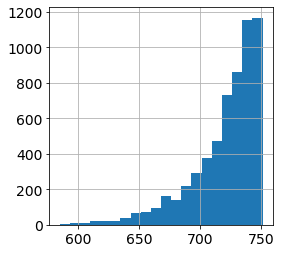

In [31]:
train_df['Credit Score'].hist(bins = 20, figsize = (4, 4))
plt.show()

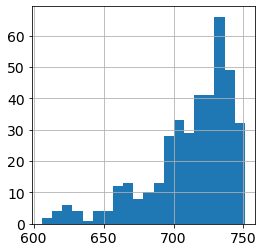

In [32]:
train_df.loc[train_df['Credit Score Outlier'] == 1, 'Credit Score'].hist(bins = 20, figsize = (4, 4))
plt.show()

## Обработка пропусков <a class='anchor' id='omission'></a>

In [33]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Maximum Open Credit Outlier        0
Current Loan Amount Outlier        0
Credit Score Outlier               0
dtype: int64

**Annual Income**

In [34]:
train_df['Annual Income'].value_counts()

1168386.0    439
1043651.0      4
1058376.0      4
969475.0       4
1338113.0      4
            ... 
1054823.0      1
959272.0       1
1788546.0      1
1399920.0      1
402192.0       1
Name: Annual Income, Length: 5049, dtype: int64

In [35]:
train_df['Annual_Income_nan'] = 0
train_df.loc[train_df['Annual Income'].isna(), 'Annual_Income_nan'] = 1
train_df['Annual_Income_nan'].value_counts()

0    5943
1    1557
Name: Annual_Income_nan, dtype: int64

In [36]:
median_ls = train_df['Annual Income'].median()
train_df['Annual Income'] = train_df['Annual Income'].fillna(median_ls)
train_df['Annual Income'].isna().sum()

0

**Years in current job**

In [37]:
years_job_mode = train_df['Years in current job'].mode().values[0]
years_job_mode

'10+ years'

In [38]:
train_df['Years in current job NaN'] = 0
train_df.loc[train_df['Years in current job'].isna(), 'Years in current job NaN'] = 1
train_df['Years in current job'].fillna(years_job_mode, inplace = True)

In [39]:
train_df['Years in current job'].isna().sum()

0

**Months since last delinquent**

In [40]:
train_df.drop('Months since last delinquent', axis=1, inplace=True)

**Bankruptcies**

In [41]:
train_df['Bankruptcies Nan'] = 0
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies Nan'] = 1
train_df['Bankruptcies Nan'].value_counts()

0    7486
1      14
Name: Bankruptcies Nan, dtype: int64

In [42]:
median_ls = train_df['Bankruptcies'].median()
train_df['Bankruptcies'] = train_df['Bankruptcies'].fillna(median_ls)
train_df['Bankruptcies'].isna().sum()

0

**Credit Score**

In [43]:
train_df['Credit Score'].value_counts()

740.0    184
747.0    172
748.0    163
741.0    155
745.0    155
        ... 
631.0      1
590.0      1
589.0      1
609.0      1
641.0      1
Name: Credit Score, Length: 160, dtype: int64

In [44]:
train_df['Credit Score Nan'] = 0
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score Nan'] = 1
train_df['Annual_Income_nan'].value_counts()

0    5943
1    1557
Name: Annual_Income_nan, dtype: int64

In [45]:
median_ls = train_df['Credit Score'].median()
train_df['Credit Score'] = train_df['Credit Score'].fillna(median_ls)
train_df['Credit Score'].isna().sum()

0

## Функция подготовки исходных данных<a class='anchor' id='preprocessing'></a>

In [46]:
class DataPreprocessing:

    def __init__(self):
        self.medians = None
        self.modes = None
        self.max_score = 850
        self.max_credit = 99999999.0
        
# Статистика
    def fit(self, df):     
        # Расчет медиан
        self.medians = df.median()
        self.modes = df.mode().loc[0]
    
# Трансформация данных
    def transform(self, df):
        df = reduce_mem_usage(df)
        
         #Выбросы
        
        # Credit score
        df['Credit Score Outlier'] = 0
    
        df.loc[df['Credit Score'] > self.max_score, 'Credit Score Outlier'] = 1

        df.loc[df['Credit Score'] > self.max_score, 'Credit Score'] = \
                                df.loc[df_train['Credit Score'] > self.max_score, 'Credit Score'] / 10
       
        #Annual Income       
        df.loc[(df['Annual Income'] > 2500000), 'Annual Income'] = self.medians['Annual Income']
        
        #Current Credit Balance
        df.loc[(df['Current Credit Balance'] > 800000), 'Current Credit Balance'] = self.medians['Current Credit Balance']
        
        #Monthly Debt
        df.loc[(df['Monthly Debt'] > 45000), 'Monthly Debt'] = self.medians['Monthly Debt']
        
        # Current Loan Amount
        df['Current Loan Amount Outlier'] = 0
        df.loc[df['Current Loan Amount'] == self.max_credit, 'Current Loan Amount Outlier'] = 1
        df.loc[df['Current Loan Amount'] == self.max_credit, 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        # Maximum Open Credit
        df['Maximum Open Credit Outlier'] = 0
        df.loc[df['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
        df.loc[df['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = max_credit
        
        
        # Пропуски
        
        #Annual Income
        df['Annual_Income_nan'] = 0
        df.loc[df['Annual Income'].isna(), 'Annual_Income_nan'] = 1
        df['Annual Income'].fillna(self.medians['Annual Income'], inplace=True)
        
        #Years in current job
        df['Years in current job NaN'] = 0
        df.loc[X['Years in current job'].isna(), 'Years in current job NaN'] = 1
        df['Years in current job'].fillna(self.modes['Years in current job'], inplace = True)
        
        #Months since last delinquent
#        df.drop('Months since last delinquent', axis=1, inplace=True)
        
        #Bankruptcies
        df['Bankruptcies Nan'] = 0
        df.loc[df['Bankruptcies'].isna(), 'Bankruptcies Nan'] = 1
        df['Bankruptcies'].fillna(self.medians['Bankruptcies'], inplace=True)
        
        #Credit score
        df['Credit Score Nan'] = 0
        df.loc[df['Credit Score'].isna(), 'Credit Score Nan'] = 1
        df['Credit Score'].fillna(self.medians['Credit Score'], inplace=True)
        
        return df

## Построение новых признаков<a class='anchor' id='new_features'></a>

**Отношение кредита к доходу**

In [47]:
train_df['Credit to income ratio'] = np.round((train_df['Annual Income']/12) / train_df['Monthly Debt'], 3) 

In [48]:
train_df.loc[train_df['Credit to income ratio'] == np.inf, ['Credit to income ratio']] = train_df['Credit to income ratio'].median()

**Отношение кредита к доходу**

In [49]:
train_df['Loan to income ratio'] = np.round((train_df['Annual Income']/12) / train_df['Current Loan Amount'], 3)

In [50]:
train_df.loc[train_df['Loan to income ratio'] == np.inf, ['Loan to income ratio']] = train_df['Loan to income ratio'].median()

## Функция построения новых признаков<a class='anchor' id='generator'></a>

In [51]:
class FeatureGenerator:
    def __init__(self):
        self.median = None
        
    def fit(self, df, y=None):
        self.medians = df.median()

    def transform(self, df):
        df = reduce_mem_usage(df)
        
        # 'Credit to income ratio'
        df['Credit to income ratio'] = np.round((df['Annual Income']/12) / df['Monthly Debt'], 3)
        df.loc[df['Credit to income ratio'] == np.inf, ['Credit to income ratio']] = df['Credit to income ratio'].median()
        
        # 'Loan to income ratio'
        #df['Loan to income ratio'] = np.round((df['Annual Income']/12) / df['Current Loan Amount'], 3)
        #df.loc[df['Loan to income ratio'] == np.inf, ['Loan to income ratio']] = df['Loan to income ratio'].median()
        
        return df

## Отбор признаков  <a class='anchor' id='feature_selection'></a>

In [52]:
feature_names = ['Annual Income', 
                'Tax Liens', 
                 'Number of Open Accounts', 
                 'Years of Credit History', 
                 'Maximum Open Credit', 
                 'Number of Credit Problems', 
#                 'Months since last delinquent', 
                 'Bankruptcies',
                 'Current Loan Amount', 
                 'Current Credit Balance', 
                 'Monthly Debt', 
                 'Credit Score', 
                 'Years in current job', 
                 'Purpose'
                ]

new_feature_names = ['Annual_Income_nan',
                     'Years in current job NaN',
                     'Bankruptcies Nan',
                     'Credit Score Nan',
                     'Current Loan Amount Outlier',
                     'Credit to income ratio',
#                     'Loan to income ratio'
#                     'Maximum Open Credit Outlier',
#                     'Credit Score Outlier'
                    ]

cat_feature_names = ['Years in current job', 'Purpose']

target_name = 'Credit Default'

## Разбиение на train и test<a class='anchor' id='train_test'></a>

In [53]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

X = df_train.drop(columns=[target_name])
y = df_train[target_name]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [55]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)  #  fit применяем только к X_train

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)
df_test = preprocessor.transform(df_test)

Memory usage of dataframe is 0.65 MB
Memory usage after optimization is: 0.42 MB
Decreased by 35.3%
Memory usage of dataframe is 0.32 MB
Memory usage after optimization is: 0.21 MB
Decreased by 35.3%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.19 MB
Decreased by 37.5%


In [56]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)  #  fit применяем только к X_train, y_train

X_train = features_gen.transform(X_train)
X_test = features_gen.transform(X_test)
df_test = features_gen.transform(df_test)

Memory usage of dataframe is 0.69 MB
Memory usage after optimization is: 0.46 MB
Decreased by 34.0%
Memory usage of dataframe is 0.34 MB
Memory usage after optimization is: 0.22 MB
Decreased by 34.0%
Memory usage of dataframe is 0.32 MB
Memory usage after optimization is: 0.21 MB
Decreased by 36.0%


In [57]:
X_train = X_train[feature_names + new_feature_names]
X_test = X_test[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

## Построение модели <a class='anchor' id='model'></a>

**Обучение**

In [58]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5537482319660536

In [59]:
model_catb = catb.CatBoostClassifier(
                                     silent=True, 
                                     random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=50,
                                     max_depth=5,
                                     min_data_in_leaf=5,
                                     cat_features=cat_feature_names,
                                        )
print(X_train.shape)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

(5025, 19)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**Оценка модели**

In [60]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN
 0.51
TEST
 0.512
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.39      0.54      3611
           1       0.36      0.88      0.51      1414

    accuracy                           0.52      5025
   macro avg       0.63      0.63      0.52      5025
weighted avg       0.74      0.52      0.53      5025

VALID

              precision    recall  f1-score   support

           0       0.90      0.38      0.53      1776
           1       0.36      0.89      0.51       699

    accuracy                           0.52      2475
   macro avg       0.63      0.63      0.52      2475
weighted avg       0.74      0.52      0.53      2475

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               670  1106
1                78   621


## Прогнозирование на тестовом датасете<a class='anchor' id='prediction'></a>

In [61]:
submit = pd.read_csv(SUBMISSION_DATASET_PATH)
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [62]:
predictions = model_catb.predict(df_test)
predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [63]:
len(predictions)

2500

In [64]:
submit['Credit Default'] = predictions

In [65]:
submit.to_csv('final_submit.csv', encoding='utf-8', index=False)